# Lazo de control del motor

## 1. Modelo de motor rotacional simple

**Variables**

* $\theta(t)$: posición angular del motor \[°]
* $\omega(t) = \frac{d\theta}{dt}$: velocidad angular \[°/s]
* $u(t)$: señal de entrada, proporcional al **torque aplicado**
* $J$: inercia del motor \[kg·m²] (usada como un factor de tiempo de respuesta)
* $b$: coeficiente de **fricción viscosa** \[N·m·s/rad]
* $\tau_s$: **torque de fricción estática** (umbral mínimo para vencer el reposo)
* $\omega_{\text{max}}$: **velocidad máxima permitida**

**Ecuación del movimiento rotacional**

$$
J \cdot \frac{d\omega(t)}{dt} = u(t) - b \cdot \omega(t) - \tau_{\text{fricción estática}}(\omega, u)
$$

Donde el término de fricción estática se comporta como:

$$
\tau_{\text{fricción estática}} =
\begin{cases}
u(t) & \text{si } |\omega| = 0 \text{ y } |u| < \tau_s \quad \text{(no se mueve)} \\
0 & \text{en caso contrario}
\end{cases}
$$

**Saturación de velocidad**

Después de actualizar $\omega(t)$, se impone:

$$
\omega(t) \leftarrow \text{clip}(\omega(t), -\omega_{\text{max}}, +\omega_{\text{max}})
$$


**Integración discreta**

Se hace integración numérica de Euler:

$$
\omega_{k+1} = \omega_k + \Delta t \cdot \frac{1}{J} \left(u_k - b \cdot \omega_k - \tau_s^\prime \right)
$$

$$
\theta_{k+1} = \theta_k + \Delta t \cdot \omega_k
$$

Donde $\tau_s^\prime = u_k$ si el motor está detenido y el torque es insuficiente.

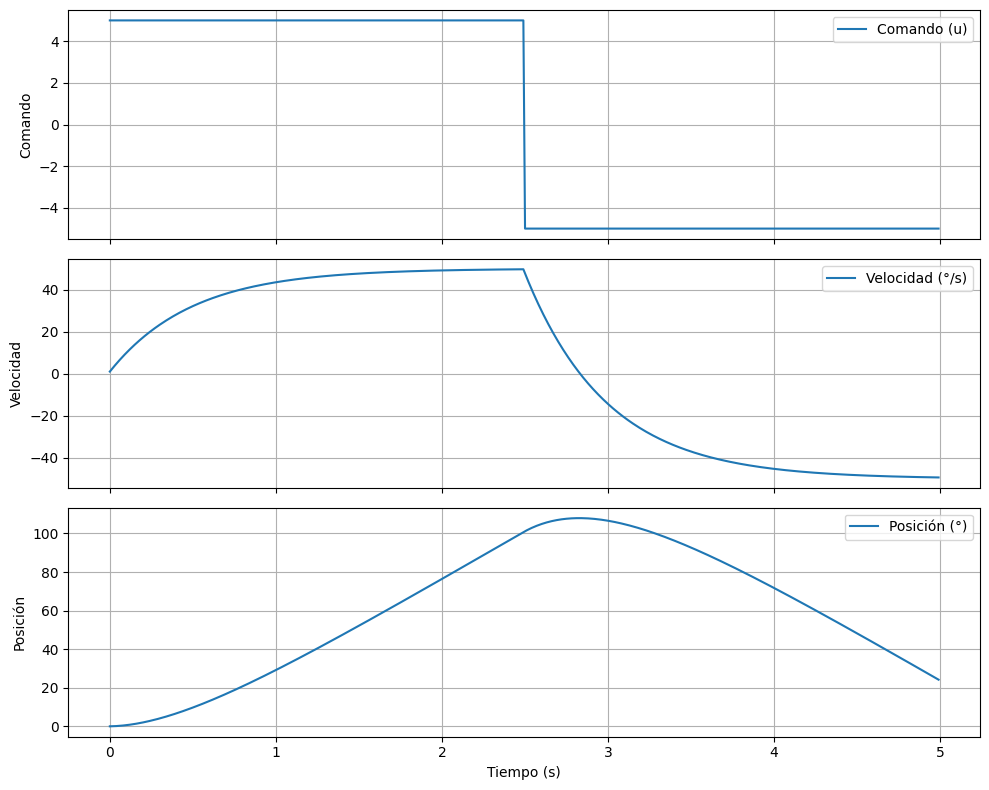

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del modelo
dt = 0.01  # paso de simulación en segundos
t_final = 5.0  # duración total en segundos
time = np.arange(0, t_final, dt)

# Parámetros físicos simulados
inertia = 0.05  # inercia (kg*m^2)
damping = 0.1   # fricción viscosa (Nm/(rad/s))
static_friction_threshold = 1.0  # umbral mínimo de torque para vencer fricción estática
max_velocity = 50.0  # velocidad máxima en grados/segundo

# Estado inicial
velocity = 0.0  # grados/seg
position = 0.0  # grados

# Arrays para graficar
velocities = []
positions = []
commands = []

# Señal de entrada: un pulso que cambia de dirección a mitad de la simulación
def control_signal(t):
    return 5.0 if t < t_final / 2 else -5.0  # Voltaje o señal de control arbitraria

for t in time:
    u = control_signal(t)
    torque = u  # En este modelo, el voltaje es proporcional al torque

    # Fricción estática
    if abs(torque) < static_friction_threshold and abs(velocity) < 1e-3:
        acceleration = 0.0  # el motor no se mueve
    else:
        net_torque = torque - damping * velocity
        acceleration = net_torque / inertia

    # Integración (Euler explícito)
    velocity += acceleration * dt
    position += velocity * dt

    # Saturación de velocidad
    if velocity > max_velocity:
        velocity = max_velocity
    elif velocity < -max_velocity:
        velocity = -max_velocity

    # Almacenamos para graficar
    velocities.append(velocity)
    positions.append(position)
    commands.append(u)

# Graficamos
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axs[0].plot(time, commands, label="Comando (u)")
axs[0].set_ylabel("Comando")
axs[0].legend()
axs[0].grid()

axs[1].plot(time, velocities, label="Velocidad (°/s)")
axs[1].set_ylabel("Velocidad")
axs[1].legend()
axs[1].grid()

axs[2].plot(time, positions, label="Posición (°)")
axs[2].set_ylabel("Posición")
axs[2].set_xlabel("Tiempo (s)")
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()

## 2. Encoder con ruido

## 3. Controlador de velocidad

## 4. Planificador de trayectoria

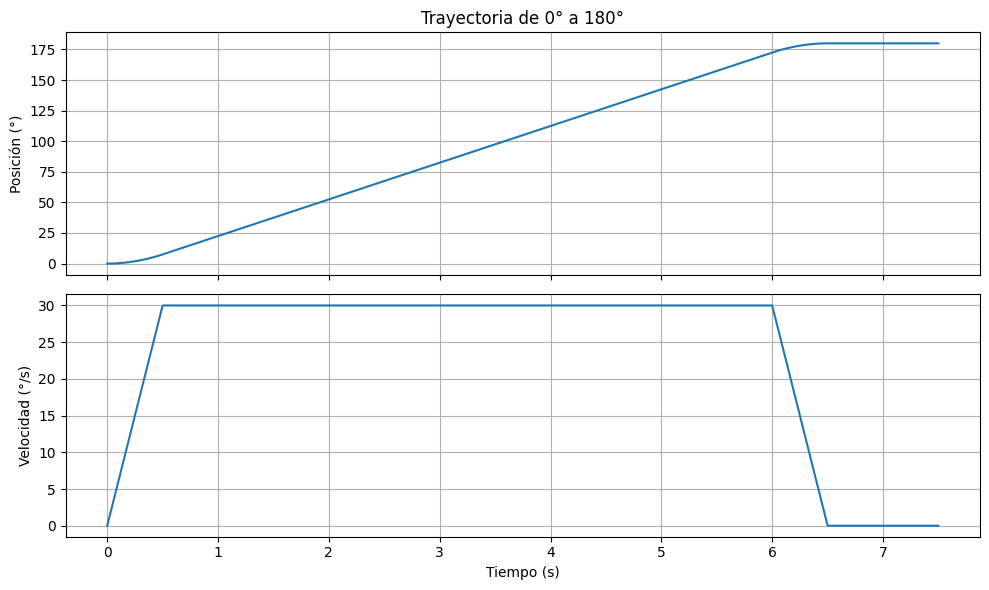

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class TrajectoryPlanner:
    def __init__(self, start_pos, end_pos, max_vel, accel):
        self.start_pos = start_pos
        self.end_pos = end_pos
        self.max_vel = max_vel
        self.accel = accel
        self.compute_profile()

    def compute_profile(self):
        d = self.end_pos - self.start_pos
        self.direction = np.sign(d)
        d = abs(d)

        t_acc = self.max_vel / self.accel
        d_acc = 0.5 * self.accel * t_acc**2

        if 2 * d_acc > d:
            # triangular profile
            self.t_acc = np.sqrt(d / self.accel)
            self.t_flat = 0
        else:
            self.t_acc = t_acc
            self.t_flat = (d - 2 * d_acc) / self.max_vel

        self.total_time = 2 * self.t_acc + self.t_flat
        self.distance = d

    def evaluate(self, t):
        a = self.accel
        ta = self.t_acc
        tf = self.t_flat
        d = self.distance

        if t < 0:
            return self.start_pos, 0
        elif t < ta:
            v = a * t
            p = 0.5 * a * t**2
        elif t < ta + tf:
            v = a * ta
            p = 0.5 * a * ta**2 + v * (t - ta)
        elif t < 2 * ta + tf:
            td = t - ta - tf
            v = a * ta - a * td
            p = 0.5 * a * ta**2 + a * ta * tf + a * ta * td - 0.5 * a * td**2
        else:
            v = 0
            p = d

        p = self.start_pos + self.direction * p
        v = self.direction * v
        return p, v

def plot_trajectory(start_pos, end_pos, max_vel=30.0, accel=60.0):
    planner = TrajectoryPlanner(start_pos, end_pos, max_vel, accel)
    t_vals = np.linspace(0, planner.total_time + 1.0, 1000)
    pos_vals = []
    vel_vals = []

    for t in t_vals:
        pos, vel = planner.evaluate(t)
        pos_vals.append(pos)
        vel_vals.append(vel)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    ax1.plot(t_vals, pos_vals)
    ax1.set_ylabel("Posición (°)")
    ax1.set_title(f"Trayectoria de {start_pos}° a {end_pos}°")
    ax1.grid()

    ax2.plot(t_vals, vel_vals)
    ax2.set_ylabel("Velocidad (°/s)")
    ax2.set_xlabel("Tiempo (s)")
    ax2.grid()

    plt.tight_layout()
    plt.show()

plot_trajectory(0, 180)

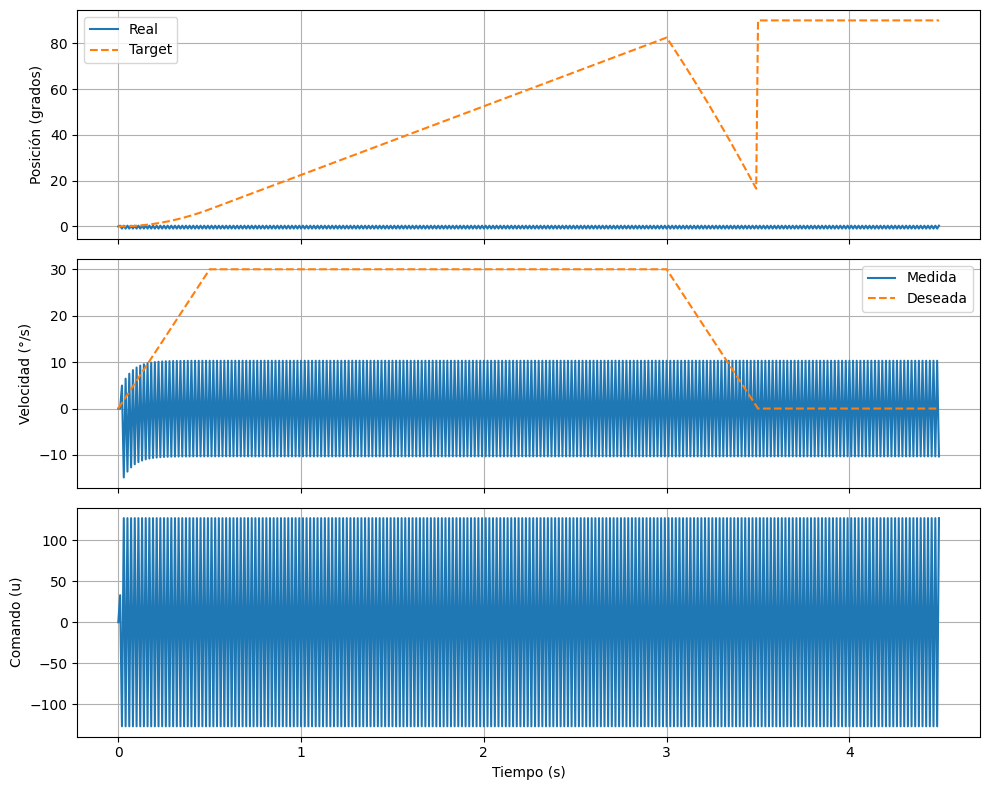

In [1]:


# Definimos clases separadas para cada componente




class VelocityEstimator:
    def __init__(self, alpha=0.9):
        self.prev_pos = None
        self.prev_time = None
        self.vel = 0
        self.alpha = alpha

    def update(self, pos, t):
        if self.prev_pos is None:
            self.prev_pos = pos
            self.prev_time = t
            return 0
        dt = t - self.prev_time
        if dt <= 0:
            return self.vel
        raw_vel = (pos - self.prev_pos) / dt
        self.vel = self.alpha * self.vel + (1 - self.alpha) * raw_vel
        self.prev_pos = pos
        self.prev_time = t
        return self.vel


class PIDController:
    def __init__(self, kp, ki, kd, umin=-127, umax=127):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.umin = umin
        self.umax = umax
        self.integral = 0
        self.prev_error = 0

    def update(self, error, dt):
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt if dt > 0 else 0
        u = self.kp * error + self.ki * self.integral + self.kd * derivative
        self.prev_error = error
        return np.clip(u, self.umin, self.umax)


# Simulación del sistema completo
planner = TrajectoryPlanner(start_pos=0, end_pos=90, max_vel=30, accel=60)
estimator = VelocityEstimator(alpha=0.85)
pid = PIDController(kp=5.0, ki=0.1, kd=0.5)

dt = 0.01
ts = np.arange(0, planner.total_time + 1, dt)

pos_real = []
vel_real = []
vel_target = []
cmd_signal = []

pos = 0

for t in ts:
    pos_target, vel_desired = planner.evaluate(t)
    vel_meas = estimator.update(pos, t)
    error = vel_desired - vel_meas
    u = pid.update(error, dt)

    # Controla el motor, asumimos proporcionalidad directa:
    pos += u * dt

    # Log
    pos_real.append(pos)
    vel_real.append(vel_meas)
    vel_target.append(vel_desired)
    cmd_signal.append(u)

# Graficamos resultados
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axs[0].plot(ts, pos_real, label="Real")
axs[0].plot(ts, [planner.evaluate(t)[0] for t in ts], "--", label="Target")
axs[0].set_ylabel("Posición (grados)")
axs[0].legend()
axs[0].grid()

axs[1].plot(ts, vel_real, label="Medida")
axs[1].plot(ts, vel_target, "--", label="Deseada")
axs[1].set_ylabel("Velocidad (°/s)")
axs[1].legend()
axs[1].grid()

axs[2].plot(ts, cmd_signal)
axs[2].set_ylabel("Comando (u)")
axs[2].set_xlabel("Tiempo (s)")
axs[2].grid()

fig.tight_layout()
plt.show()
